### Models for Predicting Particles Produced from Geant4 Simulated Electron-Proton Inelastic Scattering

**Charles Umesi 8/2023**

"***Docstring***"
<br>
Codes for three different machine learning methods were written: (i) Decision Tree (ii) Random Forest (iii) Neural Network.

***Summary***
<br>
All three methods were run twice; they performed best at predicting protons, following closely by pions. They performed poorest at predicting positrons, which were produced in the least quantity, of which neural network was the worst. The performance is consistent with data-driven machine learning. No physics-informed neural networks were used, partly because it was not obvious which was best suited to this particular problem. The application of deep neural networks to particle physics experiments is an active area of research. The data for the simulation was provided by <a href="https://www.kaggle.com/datasets/naharrison/particle-identification-from-detector-responses">Harrison</a>.


***Codes***

We start by importing relevant libraries. Considering the data; at nearly 230 MB, we will use both Dask and Pandas for the data

In [1]:
import dask.dataframe as dd

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
import pandas as pd

Alongside other libraries

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [4]:
df = dd.read_csv('/kaggle/input/particle-identification-from-detector-responses/pid-5M.csv')

In [5]:
df.head()

id         p     theta      beta  nphe       ein      eout
0   211  0.780041  1.081480  0.989962     0  0.000000  0.000000
1   211  0.260929  0.778892  0.902450     0  0.000000  0.000000
2  2212  0.773022  0.185953  0.642428     4  0.101900  0.000000
3   211  0.476997  0.445561  0.951471     0  0.000000  0.000000
4  2212  2.123290  0.337332  0.908652     0  0.034379  0.049256

Checking completeness and appropriateness of data

In [6]:
df.info

<bound method DataFrame.info of Dask DataFrame Structure:
                  id        p    theta     beta   nphe      ein     eout
npartitions=3                                                           
               int64  float64  float64  float64  int64  float64  float64
                 ...      ...      ...      ...    ...      ...      ...
                 ...      ...      ...      ...    ...      ...      ...
                 ...      ...      ...      ...    ...      ...      ...
Dask Name: read-csv, 1 graph layer>

In [7]:
df.compute().info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000000 entries, 0 to 1666934
Data columns (total 7 columns):
 #   Column  Dtype  
---  ------  -----  
 0   id      int64  
 1   p       float64
 2   theta   float64
 3   beta    float64
 4   nphe    int64  
 5   ein     float64
 6   eout    float64
dtypes: float64(5), int64(2)
memory usage: 305.2 MB


In [8]:
df.compute().isnull().sum()

id       0
p        0
theta    0
beta     0
nphe     0
ein      0
eout     0
dtype: int64

The data is as it should be! We see though, that particles are identified as numbers; it would be better if they were identified as their more standard symbols. We will do that now.

In [9]:
import unicodedata

In [10]:
def num_to_symbol(col):
    Id = col[0]
    
    if Id == -11:
        return 'e+'
    elif Id == 211:
        return unicodedata.lookup("GREEK SMALL LETTER PI")
    elif Id == 321:
        return 'K'
    else:
        return 'p'                                                    

In [11]:
# We specifically need Pandas here (see keyword argument meta)
df['id'] = df[['id']].apply(num_to_symbol,axis=1,meta=pd.Series(dtype='object'))

In [12]:
df.head()

id         p     theta      beta  nphe       ein      eout
0  π  0.780041  1.081480  0.989962     0  0.000000  0.000000
1  π  0.260929  0.778892  0.902450     0  0.000000  0.000000
2  p  0.773022  0.185953  0.642428     4  0.101900  0.000000
3  π  0.476997  0.445561  0.951471     0  0.000000  0.000000
4  p  2.123290  0.337332  0.908652     0  0.034379  0.049256

To avoid confusing momentum *p* with proton *p*, momentum's *p* will be relabelled *p_momen*

In [13]:
particles_df = df.compute()

In [14]:
particles_df.rename(columns={'p':'p_momen'},inplace=True)
particles_df.head()

id   p_momen     theta      beta  nphe       ein      eout
0  π  0.780041  1.081480  0.989962     0  0.000000  0.000000
1  π  0.260929  0.778892  0.902450     0  0.000000  0.000000
2  p  0.773022  0.185953  0.642428     4  0.101900  0.000000
3  π  0.476997  0.445561  0.951471     0  0.000000  0.000000
4  p  2.123290  0.337332  0.908652     0  0.034379  0.049256

In [15]:
plt.rcParams.update({'font.size': 8})

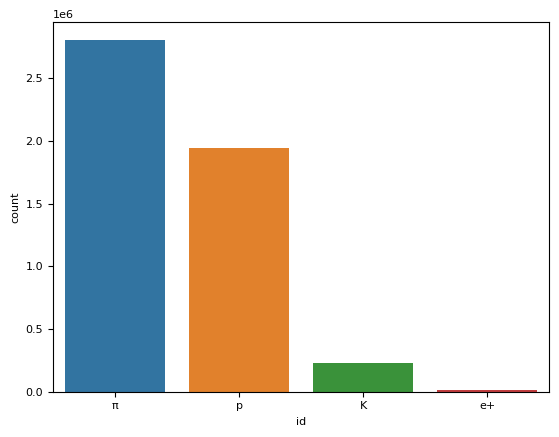

In [16]:
sns.countplot(x='id',data=particles_df)
plt.savefig('particle_id_countplot.png')

In [17]:
print(len(particles_df[particles_df['id'] == unicodedata.lookup("GREEK SMALL LETTER PI")]))
print(len(df[df['id'] == 'p']))
print(len(df[df['id'] == 'K']))
print(len(df[df['id'] == 'e+']))

2806833
1945849
232471
14847


At 2.8 million, we can see that pions (<code>&Pi;</code>) are not only the most particles produced, but they outnumber the other particles combined. This means that if we were to guess pions for all 5 million particles produced, we would be correct more than 50% of the time. Our machine learning model must perform much better than this

In [18]:
corr = particles_df.corr(numeric_only=True)

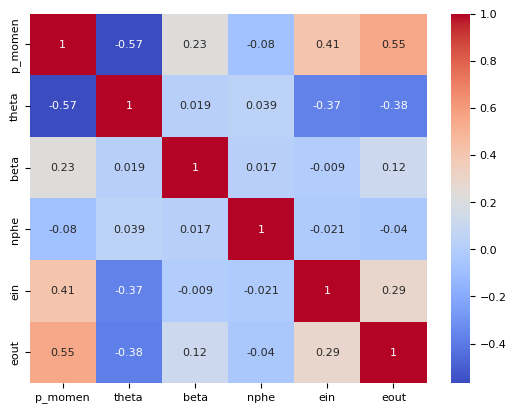

In [19]:
sns.heatmap(corr,cmap='coolwarm',annot=True)
plt.savefig('corr_heatmap.png')

We see that the strongest correlation (be it negative) occurs between momentum *p_momen* and the angle *theta*, which I presume is the <a href="http://hedberg.web.cern.ch/hedberg/lectures/ch7_lec2.pdf">deflected angle of direction</a> of the electron post-collision. From the point of view of mechanics, this makes sense as *p_momen* is a *vector* so has both *magnitude* and *direction*. This correlation is weaker (be it positive) with the other angle *beta*, which I think is the <a href="https://en.wikipedia.org/wiki/Euler_angles">angle of orientation</a> of the particle's frame of reference with respect to the detector's frame of reference. A stronger (positive) correlation exists between *p_momen* and the particle's outer energy *eout*. Again, from the point of view of mechanics, this makes sense as there is a definite mathematical relationship between *p_momen* and energy *E*

The correlations between the energies and angles are weaker but even weaker is the correlation between the inner and outer energies.

At this point, it is difficult to say how useful the correlations are. Crucially, the correlation values do not give us any *dynamic* information, which is going to be useful in helping us better understand the *behaviour* of our particles in the experiment, which we, kind of, need to know to inform our model design and evaluation.

As we have only six features, we *could* do a *pairplot* to get a general overview, but this can take hours to run...

/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight

  self._figure.tight_layout(*args, **kwargs)


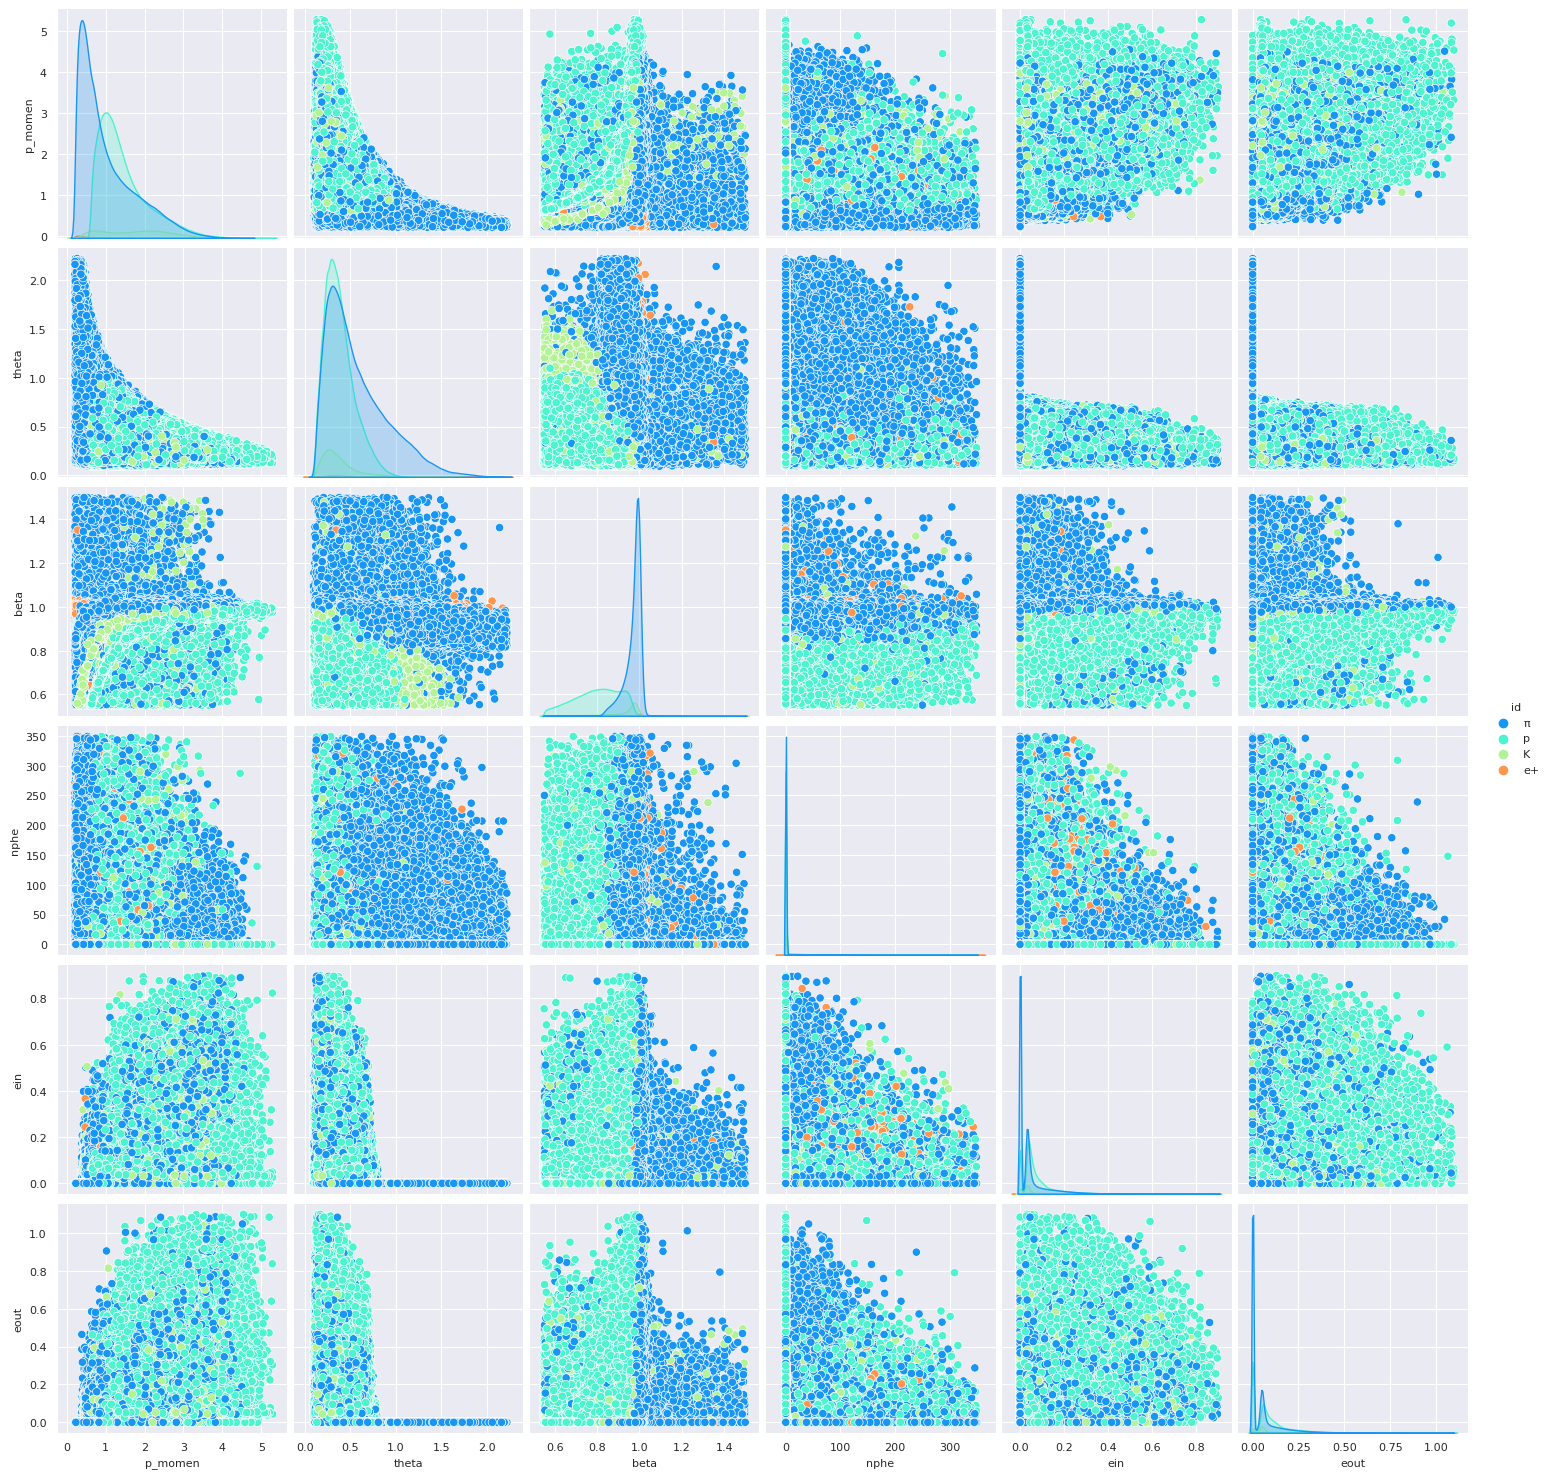

In [20]:
sns.set_style('darkgrid')
sns.pairplot(particles_df,hue='id',palette='rainbow')
plt.savefig('particle_id_pairplot.png')

Now this is interesting! We can see that when all particles are considered as a whole, then the graphs for *p_momen* vs *theta*, *p_momen* vs *eout*, and *p_momen* vs *ein*, which have the strongest correlations, broadly reflect the values of those correlations. However, when comparing the particles' momentums with their energies, we see that the particles are mixed together. This may not be surprising since energy is a scalar quantity (that is, it has only magnitude). On the other hand, when comparing particles' momentums with the angles, we see noticeable differences in the distribution of those particles; *p_momen* vs *theta* shows particularly good differences between pions (<code>&Pi;</code>) and protons (p) but *p_momen* vs *beta* shows even better differences between all four different particles. An enlarged version of *p_momen* vs *beta* is shown below

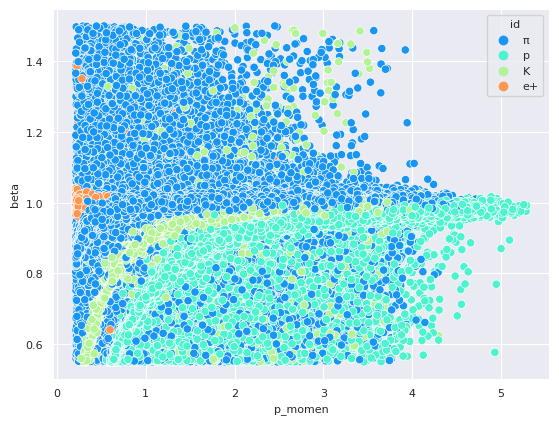

In [21]:
sns.set_style('darkgrid')
sns.scatterplot(data=particles_df,x='p_momen',y='beta',hue='id',palette='rainbow')
plt.savefig('pmomen_vs_beta.png')

As the enlarged *p_momen* vs *beta* graph shows, although the differences in distribution of the particles is quite noticeable, the differences are not absolute. This makes machine learning methods such as *K-nearest neigbours* and *K-means clustering* less suitable since they rely on highly distinct groupings of data points in order to be successful in their predictions. We will, instead, use *decision trees*, *random forests*, and *neural networks* and compare their performances.

Before we try any machine learning method, we will first convert our particle occurrences into *booleans*

In [22]:
Id = pd.get_dummies(particles_df['id'])

In [23]:
Id.head()

K  e+  p  π
0  0   0  0  1
1  0   0  0  1
2  0   0  1  0
3  0   0  0  1
4  0   0  1  0

In [24]:
particles_df = pd.concat([particles_df,Id],axis=1)
particles_df.head()

id   p_momen     theta      beta  nphe       ein      eout  K  e+  p  π
0  π  0.780041  1.081480  0.989962     0  0.000000  0.000000  0   0  0  1
1  π  0.260929  0.778892  0.902450     0  0.000000  0.000000  0   0  0  1
2  p  0.773022  0.185953  0.642428     4  0.101900  0.000000  0   0  1  0
3  π  0.476997  0.445561  0.951471     0  0.000000  0.000000  0   0  0  1
4  p  2.123290  0.337332  0.908652     0  0.034379  0.049256  0   0  1  0

Let's import our required library for *splitting* the data

In [25]:
from sklearn.model_selection import train_test_split

The first machine learning method we will use for our model is ***decision tree***


The results that follow are for 'run 2'
<br>
('Run 1' and its results can be seen at https://www.kaggle.com/charlesumesi/particle-identification-earlier-run1only; code details are identical for both runs )

In [26]:
X = particles_df[['p_momen','theta','beta','nphe','ein','eout']]
y = particles_df[['K','e+','p',unicodedata.lookup("GREEK SMALL LETTER PI")]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [27]:
from sklearn.tree import DecisionTreeClassifier

In [28]:
dtree = DecisionTreeClassifier()

In [29]:
dtree.fit(X_train,y_train)

DecisionTreeClassifier()

In [30]:
dtree_predictions = dtree.predict(X_test)

In [31]:
from sklearn.metrics import classification_report

In [32]:
print(classification_report(y_test, dtree_predictions, target_names=['K','e+','p',unicodedata.lookup("GREEK SMALL LETTER PI")]))

              precision    recall  f1-score   support



           K       0.67      0.68      0.67     69843

          e+       0.64      0.64      0.64      4396

           p       0.98      0.98      0.98    583638

           π       0.97      0.97      0.97    842123



   micro avg       0.96      0.96      0.96   1500000

   macro avg       0.81      0.82      0.82   1500000

weighted avg       0.96      0.96      0.96   1500000

 samples avg       0.96      0.96      0.96   1500000




Our model correctly predicts 97% of pions produced (i.e., the recall); now given that we would have been correct more than 50% of the time had we guessed pions for all 5 million particles, we needed our model to be way better than that, and it was. But also, the precision, in our model's prediction for pions, is very high, at 97%. Surprisingly, our model does even better for protons and unsurprisingly, it performs worst for positrons; this particle was detected the least and data-driven machine learning models notoriously perform poorly when given less data to work with.

What does our *p_momen* vs *beta* graph look like with the predictions if we swap the predicted *id* values for the observed ones, leaving everything else unchanged?

Let's find out!

In [33]:
dtree_predictions

array([[0, 0, 1, 0],
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       ...,
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [0, 0, 1, 0]], dtype=uint8)

In [34]:
particles_dtree_df = df.compute()

In [35]:
particles_dtree_df.rename(columns={'p':'p_momen'},inplace=True)

In [36]:
dtree_predictions_df = pd.DataFrame(dtree_predictions,columns=['K','e+','p',unicodedata.lookup("GREEK SMALL LETTER PI")])

In [37]:
dtree_predictions_df.head()

K  e+  p  π
0  0   0  1  0
1  0   0  0  1
2  0   0  0  1
3  0   0  0  1
4  0   0  1  0

In [38]:
particles_dtree_df = pd.concat([particles_dtree_df,dtree_predictions_df],axis=1)
particles_dtree_df.head()

id   p_momen     theta      beta  nphe       ein      eout    K   e+    p  \
0  π  0.780041  1.081480  0.989962     0  0.000000  0.000000  0.0  0.0  1.0   
1  π  0.260929  0.778892  0.902450     0  0.000000  0.000000  0.0  0.0  0.0   
2  p  0.773022  0.185953  0.642428     4  0.101900  0.000000  0.0  0.0  0.0   
3  π  0.476997  0.445561  0.951471     0  0.000000  0.000000  0.0  0.0  0.0   
4  p  2.123290  0.337332  0.908652     0  0.034379  0.049256  0.0  0.0  1.0   

     π  
0  0.0  
1  1.0  
2  1.0  
3  1.0  
4  0.0

We shall now amend the values in the *id* column to correspond with our model's predictions

In [39]:
def amend_id(col):
    K = col[0]
    e_pos = col[1]
    p = col[2]
    pi = col[3]
    
    if K == 1.0 and e_pos == 0.0 and p == 0.0 and pi == 0.0:
        return 'K'
    elif K == 0.0 and e_pos == 1.0 and p == 0.0 and pi == 0.0:
        return 'e+'
    elif K == 0.0 and e_pos == 0.0 and p == 1.0 and pi == 0.0:
        return 'p'
    else:
        return unicodedata.lookup("GREEK SMALL LETTER PI")

In [40]:
particles_dtree_df['id'] = particles_dtree_df[['K','e+','p',unicodedata.lookup("GREEK SMALL LETTER PI")]].apply(amend_id,axis=1)

In [41]:
particles_dtree_df.head()

id   p_momen     theta      beta  nphe       ein      eout    K   e+    p  \
0  p  0.780041  1.081480  0.989962     0  0.000000  0.000000  0.0  0.0  1.0   
1  π  0.260929  0.778892  0.902450     0  0.000000  0.000000  0.0  0.0  0.0   
2  π  0.773022  0.185953  0.642428     4  0.101900  0.000000  0.0  0.0  0.0   
3  π  0.476997  0.445561  0.951471     0  0.000000  0.000000  0.0  0.0  0.0   
4  p  2.123290  0.337332  0.908652     0  0.034379  0.049256  0.0  0.0  1.0   

     π  
0  0.0  
1  1.0  
2  1.0  
3  1.0  
4  0.0

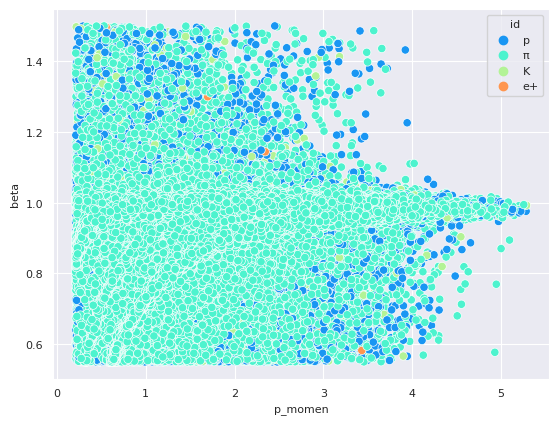

In [42]:
sns.set_style('darkgrid')
sns.scatterplot(data=particles_dtree_df,x='p_momen',y='beta',hue='id',palette='rainbow')
plt.savefig('pmomen_vs_beta_predicted_by_dtree.png')

We see that our decision tree model mislabels many particles, in particular, kaons and positrons as pions or protons, so that our predicted graph looks very different from observed results. The noticeable differences in distribution of the particles that was so characteristic of the observed graph is largely missing in the predicted graph.

Could ***random forests*** improve things?

Like before, the results that follow are for run 2
<br>
(Run 1 and its results can be seen at https://www.kaggle.com/charlesumesi/particle-identification-earlier-run1only; code details are identical for both runs)

In [43]:
from sklearn.ensemble import RandomForestClassifier

In [44]:
rfc = RandomForestClassifier(n_estimators=200)
rfc.fit(X_train,y_train)
rfc_predictions = rfc.predict(X_test)

In [45]:
print(classification_report(y_test, rfc_predictions, target_names=['K','e+','p',unicodedata.lookup("GREEK SMALL LETTER PI")]))

              precision    recall  f1-score   support



           K       0.82      0.70      0.75     69843

          e+       0.85      0.62      0.72      4396

           p       0.99      0.99      0.99    583638

           π       0.98      0.98      0.98    842123



   micro avg       0.97      0.97      0.97   1500000

   macro avg       0.91      0.82      0.86   1500000

weighted avg       0.97      0.97      0.97   1500000

 samples avg       0.97      0.97      0.97   1500000




/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.

  _warn_prf(average, modifier, msg_start, len(result))


We see, quantitatively, that random forest provides better results for kaons, but worse results for positrons although the precision is significantly better. Let us look at *p_momen* v *beta*

In [46]:
rfc_predictions

array([[0, 0, 1, 0],
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       ...,
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [0, 0, 1, 0]], dtype=uint8)

In [47]:
particles_rfc_df = df.compute()

In [48]:
particles_rfc_df.rename(columns={'p':'p_momen'},inplace=True)
rfc_predictions_df = pd.DataFrame(rfc_predictions,columns=['K','e+','p',unicodedata.lookup("GREEK SMALL LETTER PI")])
rfc_predictions_df.head()

K  e+  p  π
0  0   0  1  0
1  0   0  0  1
2  0   0  0  1
3  0   0  0  1
4  0   0  1  0

In [49]:
particles_rfc_df = pd.concat([particles_rfc_df,rfc_predictions_df],axis=1)
particles_rfc_df.head()

id   p_momen     theta      beta  nphe       ein      eout    K   e+    p  \
0  π  0.780041  1.081480  0.989962     0  0.000000  0.000000  0.0  0.0  1.0   
1  π  0.260929  0.778892  0.902450     0  0.000000  0.000000  0.0  0.0  0.0   
2  p  0.773022  0.185953  0.642428     4  0.101900  0.000000  0.0  0.0  0.0   
3  π  0.476997  0.445561  0.951471     0  0.000000  0.000000  0.0  0.0  0.0   
4  p  2.123290  0.337332  0.908652     0  0.034379  0.049256  0.0  0.0  1.0   

     π  
0  0.0  
1  1.0  
2  1.0  
3  1.0  
4  0.0

In [50]:
particles_rfc_df['id'] = particles_rfc_df[['K','e+','p',unicodedata.lookup("GREEK SMALL LETTER PI")]].apply(amend_id,axis=1)
particles_rfc_df.head()

id   p_momen     theta      beta  nphe       ein      eout    K   e+    p  \
0  p  0.780041  1.081480  0.989962     0  0.000000  0.000000  0.0  0.0  1.0   
1  π  0.260929  0.778892  0.902450     0  0.000000  0.000000  0.0  0.0  0.0   
2  π  0.773022  0.185953  0.642428     4  0.101900  0.000000  0.0  0.0  0.0   
3  π  0.476997  0.445561  0.951471     0  0.000000  0.000000  0.0  0.0  0.0   
4  p  2.123290  0.337332  0.908652     0  0.034379  0.049256  0.0  0.0  1.0   

     π  
0  0.0  
1  1.0  
2  1.0  
3  1.0  
4  0.0

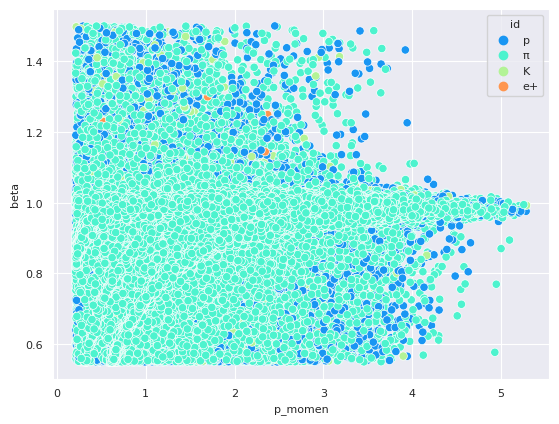

In [51]:
sns.set_style('darkgrid')
sns.scatterplot(data=particles_rfc_df,x='p_momen',y='beta',hue='id',palette='rainbow')
plt.savefig('pmomen_vs_beta_predicted_by_rfc.png')

Now that's interesting... the *p_momen* vs *beta* graph is similar to decision tree's, but in <a href="https://www.kaggle.com/charlesumesi/particle-identification-earlier-run1only">run 1</a>, it actually looks quite different. In neither of the runs was <code>random_state</code> set. That said,random forest is a stochastic rather than deterministic method.

Let us look at **neural network**

Again, like before, the results that follow are for run 2
<br>
(Run 1 and its results can be seen at https://www.kaggle.com/charlesumesi/particle-identification-earlier-run1only; code details are identical for both runs)

Unlike previous methods, we will programmatically enable Kaggle's TPU (which has already 'checked') in order to use this method

In [52]:
# First, import additional libraries essential to neural networks

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

D0802 14:02:17.886293683      15 config.cc:119]                        gRPC EXPERIMENT tcp_frame_size_tuning               OFF (default:OFF)
D0802 14:02:17.886317168      15 config.cc:119]                        gRPC EXPERIMENT tcp_rcv_lowat                       OFF (default:OFF)
D0802 14:02:17.886320696      15 config.cc:119]                        gRPC EXPERIMENT peer_state_based_framing            OFF (default:OFF)
D0802 14:02:17.886323529      15 config.cc:119]                        gRPC EXPERIMENT flow_control_fixes                  ON  (default:ON)
D0802 14:02:17.886326295      15 config.cc:119]                        gRPC EXPERIMENT memory_pressure_controller          OFF (default:OFF)
D0802 14:02:17.886329273      15 config.cc:119]                        gRPC EXPERIMENT unconstrained_max_quota_buffer_size OFF (default:OFF)
D0802 14:02:17.886331980      15 config.cc:119]                        gRPC EXPERIMENT new_hpack_huffman_decoder           ON  (default:ON)
D0802 14:02:17.

In [53]:
import tensorflow as tf

In [54]:
X = particles_df[['p_momen','theta','beta','nphe','ein','eout']].values
y = particles_df[['K','e+','p',unicodedata.lookup("GREEK SMALL LETTER PI")]].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [55]:
# Detect and initiate the TPU
tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()

# Instantiate a distribution strategy
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

# Instantiating the model in the strategy scope creates the model on the TPU
with tpu_strategy.scope():
    model = Sequential()
    model.add(Dense(6,activation='relu'))
    model.add(Dense(4,activation='softmax'))
    model.compile(optimizer='adam',loss='categorical_crossentropy',steps_per_execution=64)

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.
INFO:tensorflow:Initializing the TPU system: local
INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


In [56]:
BATCH_SIZE = 16 * tpu_strategy.num_replicas_in_sync

In [57]:
model.fit(x=X_train,y=y_train,epochs=25,validation_data=(X_test,y_test))

Epoch 1/25
109375/109375 [==============================] - 308s 3ms/step - loss: 0.1820 - val_loss: 0.1475
Epoch 2/25
109375/109375 [==============================] - 307s 3ms/step - loss: 0.1343 - val_loss: 0.1203
Epoch 3/25
109375/109375 [==============================] - 306s 3ms/step - loss: 0.1169 - val_loss: 0.1144
Epoch 4/25
109375/109375 [==============================] - 306s 3ms/step - loss: 0.1145 - val_loss: 0.1133
Epoch 5/25
109375/109375 [==============================] - 307s 3ms/step - loss: 0.1137 - val_loss: 0.1126
Epoch 6/25
109375/109375 [==============================] - 306s 3ms/step - loss: 0.1132 - val_loss: 0.1130
Epoch 7/25
109375/109375 [==============================] - 307s 3ms/step - loss: 0.1129 - val_loss: 0.1118
Epoch 8/25
109375/109375 [==============================] - 307s 3ms/step - loss: 0.1128 - val_loss: 0.1122
Epoch 9/25
109375/109375 [==============================] - 307s 3ms/step - loss: 0.1126 - val_loss: 0.1115
Epoch 10/25
109375/109375 [=

<Axes: >

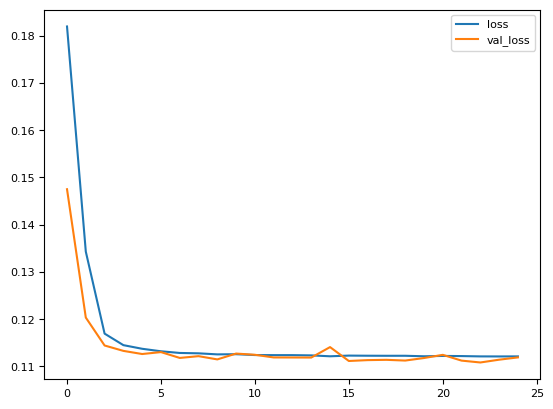

In [58]:
# Check for 'overfitting'
loss_df = pd.DataFrame(model.history.history)
loss_df.plot()

No *overfitting* seen

In [59]:
# Backup neural network
model.save('particle_id_nn1.h5')

In [60]:
predictions = model.predict(X_test)
nn_predictions = np.round(predictions)
nn_predictions

2023-08-02 16:18:22.046549: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-08-02 16:18:22.098382: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


46875/46875 [==============================] - 84s 2ms/step


array([[0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       ...,
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.]], dtype=float32)

In [61]:
# from tensorflow.keras.models import load_model  # If using backup neural network
# model = load_model('particle_id_nn1.h5')

In [62]:
print(classification_report(y_test, nn_predictions, target_names=['K','e+','p',unicodedata.lookup("GREEK SMALL LETTER PI")]))

              precision    recall  f1-score   support

           K       0.80      0.61      0.69     69514
          e+       0.80      0.42      0.55      4558
           p       0.98      0.99      0.99    583452
           π       0.97      0.98      0.98    842476

   micro avg       0.97      0.96      0.97   1500000
   macro avg       0.89      0.75      0.80   1500000
weighted avg       0.97      0.96      0.96   1500000
 samples avg       0.96      0.96      0.96   1500000



/usr/local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


We see that our neural network performs worse than random forest on all four particles and its performance for kaons and positrons is even worse than decision tree.

Let us see *p_momen* vs *beta*

In [63]:
particles_nn_df = df.compute()

In [64]:
particles_nn_df.rename(columns={'p':'p_momen'},inplace=True)
nn_predictions_df = pd.DataFrame(nn_predictions,columns=['K','e+','p',unicodedata.lookup("GREEK SMALL LETTER PI")])
nn_predictions_df.head()

K   e+    p    π
0  0.0  0.0  0.0  1.0
1  0.0  0.0  1.0  0.0
2  0.0  0.0  0.0  1.0
3  0.0  0.0  0.0  1.0
4  0.0  0.0  0.0  1.0

In [65]:
particles_nn_df = pd.concat([particles_nn_df,nn_predictions_df],axis=1)
particles_nn_df.head()

id   p_momen     theta      beta  nphe       ein      eout    K   e+    p  \
0  π  0.780041  1.081480  0.989962     0  0.000000  0.000000  0.0  0.0  0.0   
1  π  0.260929  0.778892  0.902450     0  0.000000  0.000000  0.0  0.0  1.0   
2  p  0.773022  0.185953  0.642428     4  0.101900  0.000000  0.0  0.0  0.0   
3  π  0.476997  0.445561  0.951471     0  0.000000  0.000000  0.0  0.0  0.0   
4  p  2.123290  0.337332  0.908652     0  0.034379  0.049256  0.0  0.0  0.0   

     π  
0  1.0  
1  0.0  
2  1.0  
3  1.0  
4  1.0

In [66]:
particles_nn_df['id'] = particles_nn_df[['K','e+','p',unicodedata.lookup("GREEK SMALL LETTER PI")]].apply(amend_id,axis=1)
particles_nn_df.head()

id   p_momen     theta      beta  nphe       ein      eout    K   e+    p  \
0  π  0.780041  1.081480  0.989962     0  0.000000  0.000000  0.0  0.0  0.0   
1  p  0.260929  0.778892  0.902450     0  0.000000  0.000000  0.0  0.0  1.0   
2  π  0.773022  0.185953  0.642428     4  0.101900  0.000000  0.0  0.0  0.0   
3  π  0.476997  0.445561  0.951471     0  0.000000  0.000000  0.0  0.0  0.0   
4  π  2.123290  0.337332  0.908652     0  0.034379  0.049256  0.0  0.0  0.0   

     π  
0  1.0  
1  0.0  
2  1.0  
3  1.0  
4  1.0

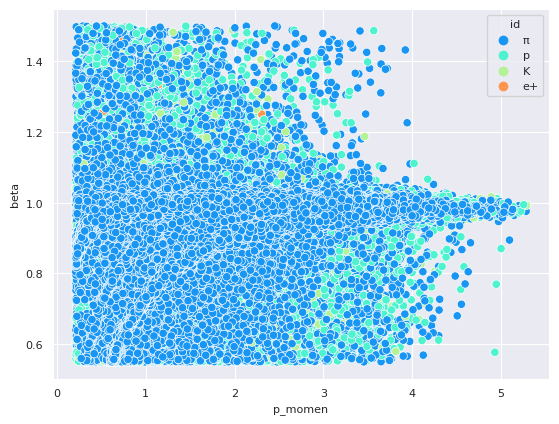

In [67]:
sns.set_style('darkgrid')
sns.scatterplot(data=particles_nn_df,x='p_momen',y='beta',hue='id',palette='rainbow')
plt.savefig('pmomen_vs_beta_predicted_by_nn.png')

Let us bring all *p_momen* vs *beta* graphs together and try to draw some final conclusions
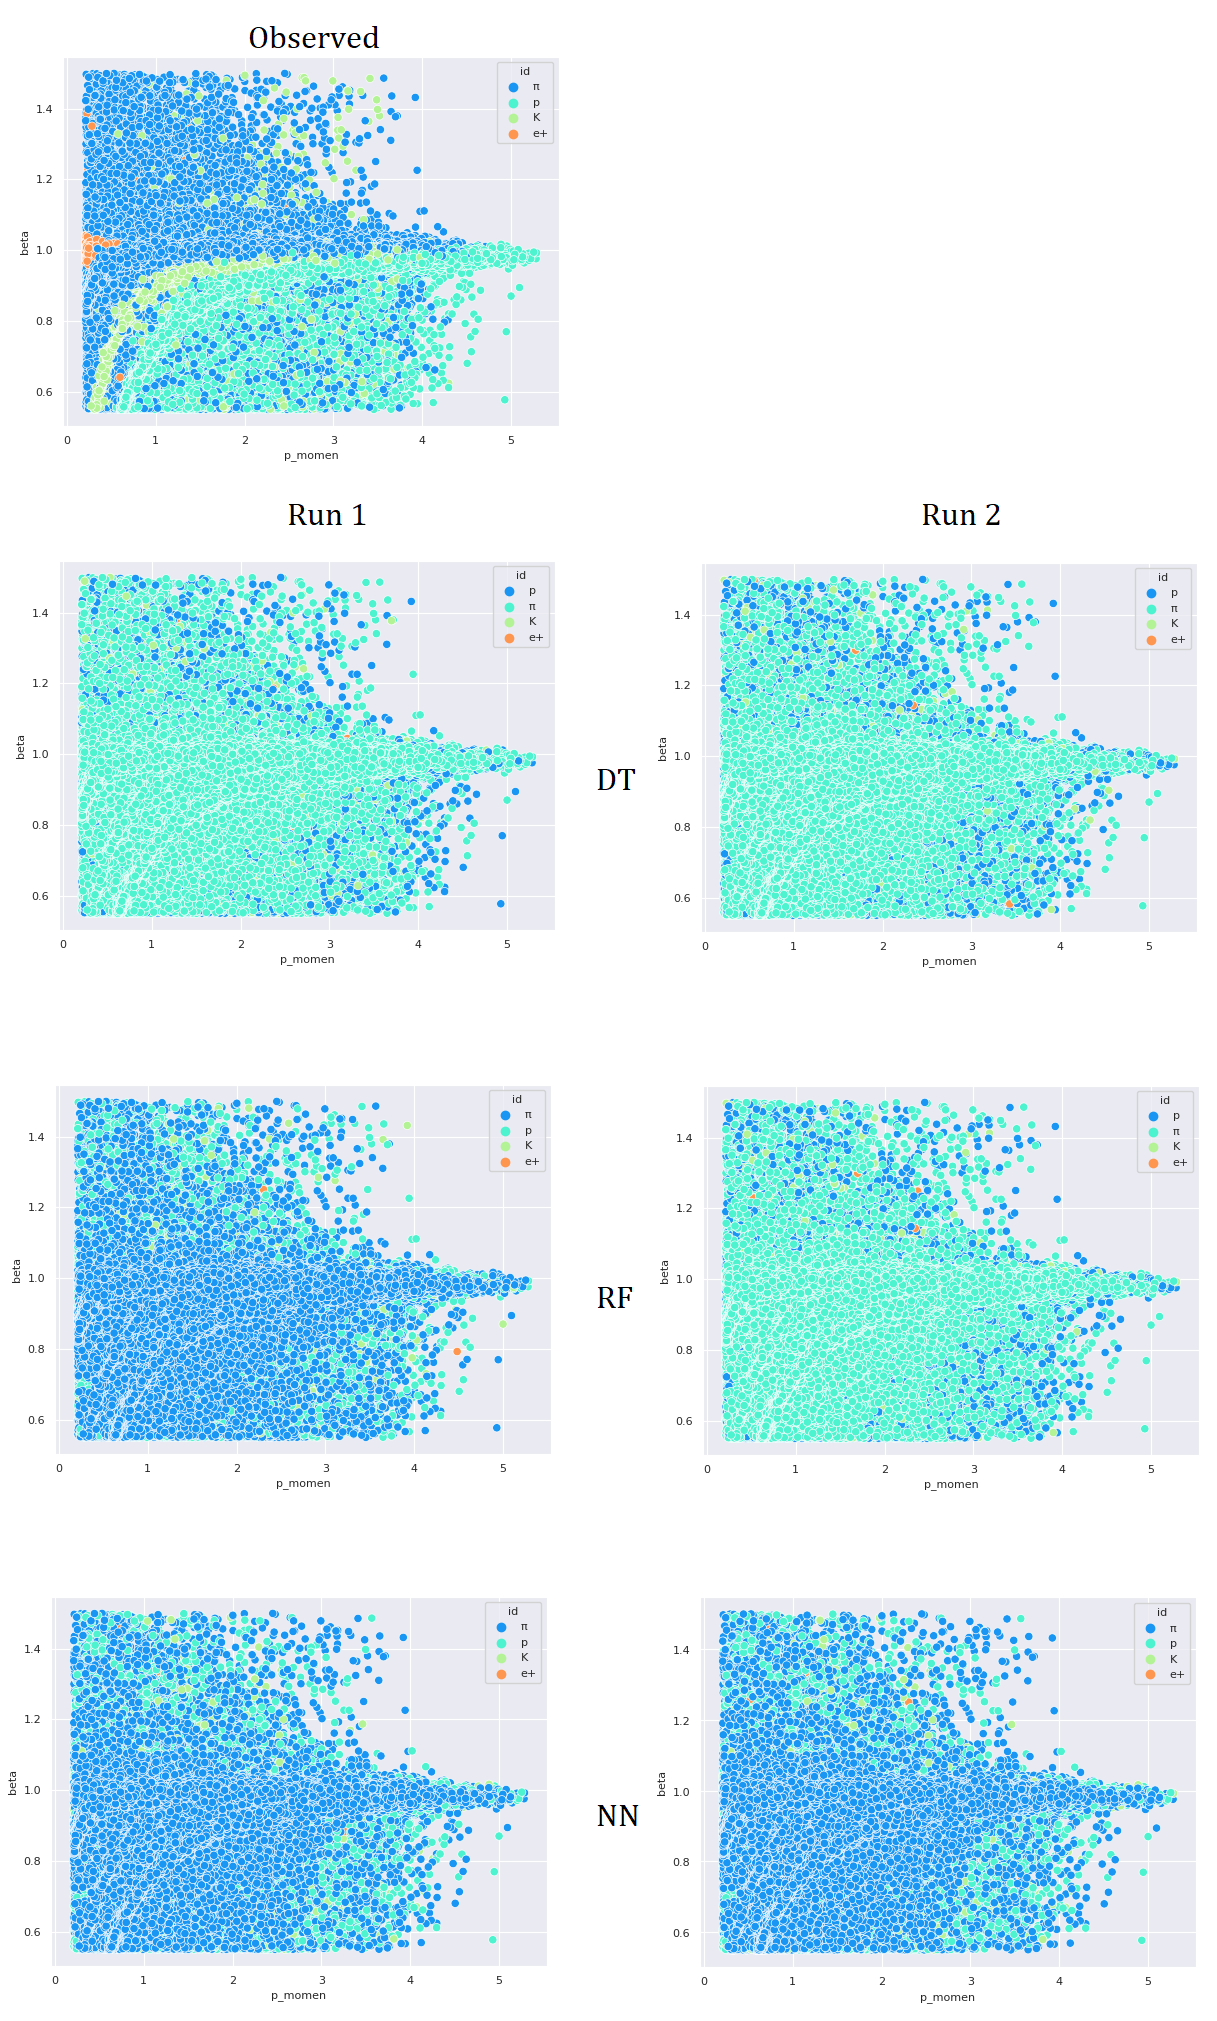

Legend: DT = Decision Tree; RF = Random Forest; NN = Neural Network

The graphs don't reveal anything particle physicists don't already know about decision trees and neural networks, which they have been using for <a href="https://cms.cern/news/using-artificial-intelligence-search-new-exotic-particles">decades</a>.

The models developed behave as would be expected for data-driven machine learning. Better performance with positrons require either more features in the data or other more arguments with the methods used or other methods employed